**Please download respective file or images such as: "q2w.h5" ; "b.jpg"; "car_name.txt"; "coco.txt"**

In [1]:
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


In [2]:
pip install tensornets

In [0]:
import tensornets as nets
import cv2
import numpy as np
import time

In [4]:
inp = tf.placeholder(tf.float32, [None, 416, 416, 3])
model = nets.YOLOv3COCO(inp, nets.Darknet19)

Instructions for updating:
Please use `layer.__call__` method instead.


In [0]:
from google.colab.patches import cv2_imshow

 2.4693660736083984 time in seconds
P.V. :  0
L.M.V. :  19
M.V. :  3
H.M.P.V. :  8
H.M.T.V. :  0


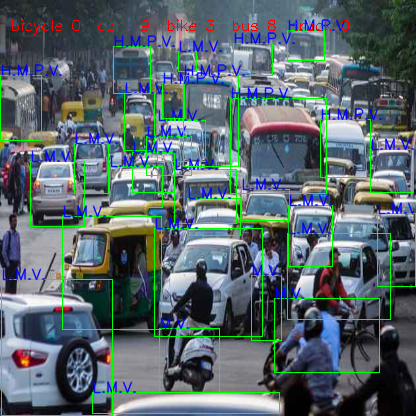

In [6]:
import random

np.random.seed()
classes_list=[1,2,3,5,7]
COLORS = np.random.randint(0, 255, size=(80, 3), dtype = "uint8")

classes_list=[1,2,3,5,7]
classes={'1':'bicycle','2':'car','3':'bike','5':'bus','7':'truck'}
with tf.Session() as ses:
    ses.run(model.pretrained())   
    
    
    img1 = cv2.imread("b.jpg")
    
    
    img=cv2.resize(img1,(416,416))
    imge=np.array(img).reshape(-1,416,416,3)
    start=time.time()
    preds = ses.run(model.preds, {inp: model.preprocess(imge)})
    

    print(" %s time in seconds" % (time.time() - start)) 
    boxes = model.get_boxes(preds, imge.shape[1:3])
    
    boxes1=np.array(boxes)
    (H, W) = imge.shape[0:2]
    
    confidence = []
    bxs = []
    cids = []
    cnt = []
    for j in classes_list:
        c =0
        if str(j) in classes:
          x=classes[str(j)]
          if x == "car":
            lab = "L.M.V."
          elif x == "bike":
            lab = "M.V."
          elif x == "truck":
            lab = "H.M.T.V."
          elif x == "bicycle":
            lab = "P.V."
          elif x == "bus":
            lab = "H.M.P.V."
          else:
            lab = x
        if len(boxes1) !=0:
            
            
            for k in range(len(boxes1[j])):
                box=boxes1[j][k]
                if boxes1[j][k][4]>=.50:
                    
                    confidence.append(float(boxes1[j][k][4]))
                         
                    c = c + 1    
                    b = box[0:4]
                    (centerX, centerY, width, height) = b.astype("int")
                    
                    
                    
                    bxs.append([int(centerX),int(centerY),int(width),int(height)])
                    
                    cids.append(j)
                    
            
                    cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),(0,255,0),1)
                   
                    cv2.putText(img, lab, (box[0],box[1]), cv2.FONT_HERSHEY_SIMPLEX, .5, (255,0,0), lineType=cv2.LINE_AA)
        cnt.append(c)
        if len(cnt)==5:
          txt = classes[str(1)]+" "+ str(cnt[0]) +"  " +classes[str(2)]+" "+ str(cnt[1]) +"  "+classes[str(3)]+" "+ str(cnt[2]) + "  "+classes[str(5)]+" "+ str(cnt[3]) + "  "+classes[str(7)]+" "+ str(cnt[4])
          cv2.putText(img,"{}".format(txt),(10,30),cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 0, 255))
        print(lab,": ",c)
               
cv2_imshow(img)  
               






In [0]:
ids = cv2.dnn.NMSBoxes(bxs, confidence, 0.40, 0.3) 

In [0]:
f = ids.flatten()

In [9]:
from keras import backend as K

Using TensorFlow backend.


In [0]:
K.set_learning_phase(0)

In [0]:
from keras.models import load_model

In [12]:
model = load_model("q2w.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.






In [13]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'vgg16_input:0' shape=(?, 224, 224, 3) dtype=float32>]
[<tf.Tensor 'dense_4/Softmax:0' shape=(?, 196) dtype=float32>]


In [14]:
# https://www.dlology.com/blog/how-to-convert-trained-keras-model-to-tensorflow-and-make-prediction/


def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 443 variables.
INFO:tensorflow:Converted 443 variables to const ops.


In [15]:
tf.train.write_graph(frozen_graph, "model", "tf_model.pb", as_text=False)

'model/tf_model.pb'

In [0]:
from tensorflow.python.platform import gfile

In [17]:
f = gfile.FastGFile("./model/tf_model.pb", "rb")

Instructions for updating:
Use tf.gfile.GFile.


In [0]:
graph_def  = tf.GraphDef()

In [19]:
graph_def.ParseFromString(f.read())

622783276

In [0]:
f.close()

In [21]:
sess = tf.Session()
sess.graph.as_default()

In [0]:
tf.import_graph_def(graph_def)

In [23]:
softmax_tensor = sess.graph.get_tensor_by_name('import/dense_4/Softmax:0')
print(softmax_tensor)

Tensor("import/dense_4/Softmax:0", shape=(?, 196), dtype=float32)


In [24]:
label_file = "car_names.txt"
label = []
with open(label_file, "r", encoding='cp1251') as ins:
    for line in ins:
        label.append(line.rstrip())

print(label)

['AM-General-Hummer-SUV-2000', 'Acura-RL-Sedan-2012', 'Acura-TL-Sedan-2012', 'Acura-TL-Type-S-2008', 'Acura-TSX-Sedan-2012', 'Acura-Integra-Type-R-2001', 'Acura-ZDX-Hatchback-2012', 'Aston-Martin-V8-Vantage-Convertible-2012', 'Aston-Martin-V8-Vantage-Coupe-2012', 'Aston-Martin-Virage-Convertible-2012', 'Aston-Martin-Virage-Coupe-2012', 'Audi-RS-4-Convertible-2008', 'Audi-A5-Coupe-2012', 'Audi-TTS-Coupe-2012', 'Audi-R8-Coupe-2012', 'Audi-V8-Sedan-1994', 'Audi-100-Sedan-1994', 'Audi-100-Wagon-1994', 'Audi-TT-Hatchback-2011', 'Audi-S6-Sedan-2011', 'Audi-S5-Convertible-2012', 'Audi-S5-Coupe-2012', 'Audi-S4-Sedan-2012', 'Audi-S4-Sedan-2007', 'Audi-TT-RS-Coupe-2012', 'BMW-ActiveHybrid-5-Sedan-2012', 'BMW-1-Series-Convertible-2012', 'BMW-1-Series-Coupe-2012', 'BMW-3-Series-Sedan-2012', 'BMW-3-Series-Wagon-2012', 'BMW-6-Series-Convertible-2007', 'BMW-X5-SUV-2007', 'BMW-X6-SUV-2012', 'BMW-M3-Coupe-2012', 'BMW-M5-Sedan-2010', 'BMW-M6-Convertible-2010', 'BMW-X3-SUV-2012', 'BMW-Z4-Convertible-2012

In [25]:
label_fil = "coco.txt"
labelzz = []
with open(label_fil, "r", encoding='cp1251') as ins:
    for line in ins:
        labelzz.append(line.rstrip())

print(labelzz)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [0]:
from PIL import Image, ImageOps

Top 3 predicitions with probability:[{'CarName': 'Volvo-240-Sedan-1993', 'prob': '0.22010013'}, {'CarName': 'Chevrolet-Cobalt-SS-2010', 'prob': '0.09224538'}, {'CarName': 'Suzuki-SX4-Hatchback-2012', 'prob': '0.048038293'}]
Top 3 predicitions with probability:[{'CarName': 'Nissan-Juke-Hatchback-2012', 'prob': '0.34631893'}, {'CarName': 'AM-General-Hummer-SUV-2000', 'prob': '0.2722678'}, {'CarName': 'Scion-xD-Hatchback-2012', 'prob': '0.16916098'}]
Top 3 predicitions with probability:[{'CarName': 'Chrysler-Crossfire-Convertible-2008', 'prob': '0.36334312'}, {'CarName': 'Toyota-Camry-Sedan-2012', 'prob': '0.12032585'}, {'CarName': 'Acura-Integra-Type-R-2001', 'prob': '0.06395002'}]
Top 3 predicitions with probability:[{'CarName': 'Nissan-Juke-Hatchback-2012', 'prob': '0.6762685'}, {'CarName': 'Ferrari-California-Convertible-2012', 'prob': '0.18995827'}, {'CarName': 'Nissan-NV-Passenger-Van-2012', 'prob': '0.11047057'}]
Top 3 predicitions with probability:[{'CarName': 'Jeep-Grand-Cherokee

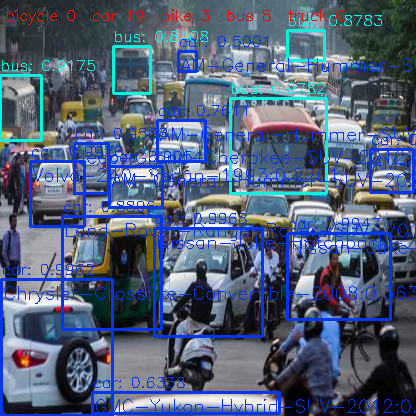

In [37]:
img2 = cv2.imread("b.jpg")
im = cv2.imread("b.jpg")
im = cv2.resize(im,(416,416))
if len(ids)>0:
  for i in ids.flatten():
    (x,y) = (bxs[i][0],bxs[i][1])
    
    (w,h) = (bxs[i][2],bxs[i][3])
    


    color = [int(cr) for cr in COLORS[cids[i]]]
    if cids[i] == 2 or cids[i]==7:
      
      
      img1[max(y,0):y+h,max(x,0):x+w,::-1]
      imgs = img1[max(y,0):y+h,max(x,0):x+w,::-1]
      size = (224,224)      
      padColor=0
      h1, w1 = imgs.shape[:2]
      sh, sw = size
      if h1 > sh or w1 > sw:
        interp = cv2.INTER_AREA
      else: 
        interp = cv2.INTER_CUBIC

          
      aspect = w1/h1  

          
      if aspect > 1:
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
      elif aspect < 1: 
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
      
      else: 
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

          
      if len(imgs.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): 
        padColor = [padColor]*3

          
      scaled_img = cv2.resize(imgs, (new_w, new_h), interpolation=interp)
      scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)



      imgs = scaled_img
      imgs = np.expand_dims(imgs,axis=0)
      imgs = imgs.astype(np.float32)
      imgs /= 127.5
      imgs -=1.

      
      predictions = sess.run(softmax_tensor, {'import/vgg16_input:0': imgs})

      predictions = np.squeeze(predictions)

      top = 3
      top_indices = predictions.argsort()[-top:][::-1]
      
      cls = []
      make_model = []
      for m in top_indices:
        make_model = label[m].strip('')
        
        cls.append({"CarName": make_model,"prob":str(predictions[m])})
      
      

      text = "{}:{:.4f}".format(cls[0]['CarName'], float(cls[0]['prob']))
      print("Top 3 predicitions with probability:"+str(cls))
      cv2.putText(im, text, (x+2,y+20), cv2.FONT_HERSHEY_SIMPLEX,0.6,color,1)

    

    cv2.rectangle(im, (x,y),(w,h),color,2)
    text = "{}: {:.4f}".format(labelzz[cids[i]], confidence[i])
    cv2.putText(im,"{}".format(txt),(5,20),cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,255))
    cv2.putText(im,text,(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,1)


cv2_imshow(im)








      
      
      
      
